In [ ]:
# https://learnopencv.com/using-facial-landmarks-for-overlaying-faces-with-masks/
# https://www.makesense.ai/

In [1]:
!git clone https://github.com/bmox/facemask-overlay.git

Cloning into 'facemask-overlay'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [2]:
!pip install mediapipe

     |████████████████████████████████| 30.1 MB 12 kB/s 


In [3]:
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow
import csv
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

In [4]:
face_mesh= mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

In [5]:
def face_point(image,drawing=False):
  img=image.copy()
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  results = face_mesh.process(image)
  faces=[]
  if results.multi_face_landmarks:
    for faceLms in results.multi_face_landmarks:
      face = []
      for id,lm in enumerate(faceLms.landmark):
          ih, iw, ic = image.shape
          x,y = int(lm.x*iw), int(lm.y*ih)
          face.append([id,x,y])     
      faces.append(face)
  
  if results.multi_face_landmarks:
    if drawing:
      for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())   
  image=cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return image,faces

In [11]:
def mask_overlay(image,faces):
  mirror_point={
      234 :1,
      93 :2,
      132 :3,
      58 :4,
      172 :5,
      136 :6,
      150 :7,
      149 :8,
      176 :9,
      148 :10,
      152 :11,
      377 :12,
      400 :13,
      378 :14,
      379 :15,
      365 :16,
      397 :17,
      288 :18,
      361 :19,
      323 :20,
      454 :21,
      195 :22
      }
  mask_img = cv2.imread("/content/facemask-overlay/mask.png", cv2.IMREAD_UNCHANGED)
  mask_img = mask_img.astype(np.float32)
  mask_img = mask_img / 255.0
  mask_annotation="/content/facemask-overlay/mask_label.csv"
  mask_points={}
  with open(mask_annotation) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=",")
    for i, row in enumerate(csv_reader):
      mask_points[int(row[0])]=[float(row[1]), float(row[2])]
  src_pts = []
  for i in sorted(mask_points.keys()):
    try:
      src_pts.append(np.array(mask_points[i]))
    except ValueError:
      continue
  src_pts = np.array(src_pts, dtype="float32")
  face_points={}
  for i in faces[0]:
    for j in mirror_point.keys():
     if i[0] ==j:
       face_points[mirror_point[j]]=[float(i[1]),float(i[2])]
  dst_pts=[]
  for i in sorted(face_points.keys()):
    # print(i,face_points[i])
    try:
      dst_pts.append(np.array(face_points[i]))
    except ValueError:
      continue
  dst_pts = np.array(dst_pts, dtype="float32") 
  M, _ = cv2.findHomography(src_pts, dst_pts)
  # transformed masked image
  transformed_mask = cv2.warpPerspective(
      mask_img,
      M,
      (image.shape[1], image.shape[0]),
      None,
      cv2.INTER_LINEAR,
      cv2.BORDER_CONSTANT,
  )
  # mask overlay
  alpha_mask = transformed_mask[:, :, 3]
  alpha_image = 1.0 - alpha_mask
  for c in range(0, 3):
      image[:, :, c] = (
          alpha_mask * transformed_mask[:, :, c]
          + alpha_image * image[:, :, c]
      )
  return image

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/8/85/Elon_Musk_Royal_Society_%28crop1%29.jpg

In [15]:
import os
os.rename("/content/Elon_Musk_Royal_Society_(crop1).jpg","image.jpg")

In [20]:
image=cv2.imread("/content/image.jpg")
image=cv2.flip(image, 1)
Image1=image.copy()
img,faces=face_point(image,drawing=True)
Image2=img.copy()
if len(faces)>=1:
  mask_image=mask_overlay(image,faces)
  Image3=mask_image.copy()

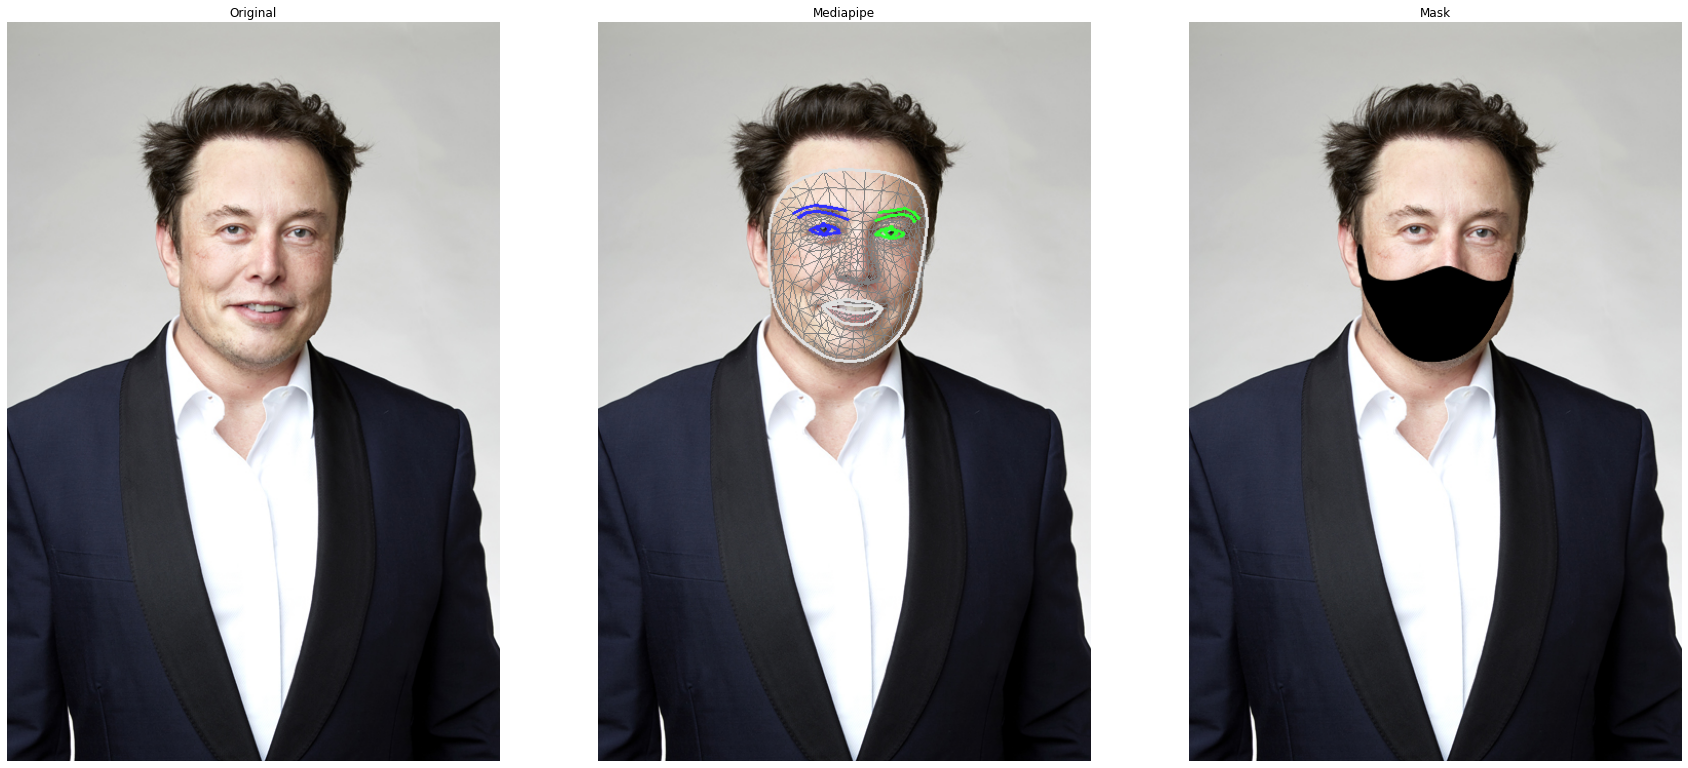

In [21]:
import cv2
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30, 15))
rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(cv2.cvtColor(Image1, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Original")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(cv2.cvtColor(Image2, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Mediapipe")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(cv2.cvtColor(Image3, cv2.COLOR_RGB2BGR))
plt.axis('off')
plt.title("Mask")

plt.show()
